In [3]:
import pandas as pd
import seaborn as sns
from nilearn.plotting import plot_img
from nilearn.image import load_img, index_img, new_img_like

import os
from scipy.stats import pearsonr

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Average distance between pipelines per region

In [8]:
region_names = sorted([x.split("/")[-1] for x in glob("clustering/roi_68/*")])

def extract_similarities(mask):

    sim_pattern_roi_alpha=[]
    for roi_name in np.sort(region_names):
        sim_pattern_roi_alpha.append(squareform(np.mean([loadmat(rec_mat)['R'][mask,:][:,mask] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/alpha/*")],
                                                  axis=0), checks=False))
    sim_pattern_roi_alpha = np.array(sim_pattern_roi_alpha)

    sim_pattern_roi_beta=[]
    for roi_name in np.sort(region_names):
        sim_pattern_roi_beta.append(squareform(np.mean([loadmat(rec_mat)['R'][mask,:][:,mask] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/beta/*")],
                                                  axis=0), checks=False))
    sim_pattern_roi_beta = np.array(sim_pattern_roi_beta)


    sim_pattern_roi_theta=[]
    for roi_name in np.sort(region_names):
        sim_pattern_roi_theta.append(squareform(np.mean([loadmat(rec_mat)['R'][mask,:][:,mask] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/theta/*")],
                                                  axis=0), checks=False))
    sim_pattern_roi_theta = np.array(sim_pattern_roi_theta)
    
    return {'alpha': sim_pattern_roi_alpha,
            'beta': sim_pattern_roi_beta,
            'theta': sim_pattern_roi_theta,
           }

def compute_distances(sim_dict):
    rois = pd.read_csv("data/rois.txt", header=None)
    rois = pd.DataFrame({'roi':rois.loc[:,0], 'roi_index': np.arange(1,83)})

    dist_alpha_68 = pd.DataFrame({'value': np.mean(1-sim_dict['alpha'], axis=1),
                                  'roi': np.sort(region_names)})
    dist_alpha_68.roi = dist_alpha_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
    dist_alpha_68 = pd.merge(rois, dist_alpha_68, on="roi")

    dist_beta_68 = pd.DataFrame({'value': np.mean(1-sim_dict['beta'], axis=1),
                                 'roi': np.sort(region_names)})
    dist_beta_68.roi = dist_beta_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
    dist_beta_68 = pd.merge(rois, dist_beta_68, on="roi")

    dist_theta_68 =  pd.DataFrame({'value': np.mean(1-sim_dict['theta'], axis=1),
                                 'roi': np.sort(region_names)})
    dist_theta_68.roi = dist_theta_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
    dist_theta_68 = pd.merge(rois, dist_theta_68, on="roi")
    
    return {'alpha': dist_alpha_68,
            'beta': dist_beta_68,
            'theta': dist_theta_68,
           }

def combine_d_size(dist_dict, seed_size_df):
    dist_alpha_68_size = pd.merge(dist_dict['alpha'], seed_size_df, on="roi")
    dist_alpha_68_size["band"]="alpha"

    dist_beta_68_size = pd.merge(dist_dict['beta'], seed_size_df, on="roi")
    dist_beta_68_size["band"]="beta"

    dist_theta_68_size = pd.merge(dist_dict['theta'], seed_size_df, on="roi")
    dist_theta_68_size["band"]="theta"

    dist_68_size = pd.concat([dist_alpha_68_size, dist_beta_68_size, dist_theta_68_size], axis=0)
    dist_68_size = dist_68_size.rename(columns={'value': 'Average Distance'})
    return dist_68_size

def generate_dist_imgs(dist_dict, output_dir):
    desikan = index_img(load_img("data/Desikan+wm_genetics_1mm.nii.gz"), 0)

    data = np.zeros_like(desikan.get_fdata())

    for _,row in dist_dict['alpha'].iterrows():
        data[desikan.get_fdata()==int(row.roi_index)] =  row.value

    dist_alpha_68_img = new_img_like(desikan, data)

    data = np.zeros_like(desikan.get_fdata())

    for _,row in dist_dict['beta'].iterrows():
        data[desikan.get_fdata()==int(row.roi_index)] =  row.value

    dist_beta_68_img = new_img_like(desikan, data)

    data = np.zeros_like(desikan.get_fdata())

    for _,row in dist_dict['theta'].iterrows():
        data[desikan.get_fdata()==int(row.roi_index)] =  row.value

    dist_theta_68_img = new_img_like(desikan, data)
    
    dist_alpha_68_img.to_filename(opj(output_dir, "d_alpha_68.nii.gz"))
    dist_beta_68_img.to_filename(opj(output_dir, "d_beta_68.nii.gz"))
    dist_theta_68_img.to_filename(opj(output_dir, "d_theta_68.nii.gz"))

def boxviolin_w_points(y, data, x=None, ax=None, points_kws = None, violin_kws = None, box_kws=None):
    
    from pingouin import compute_bootci
    
    if ax is None:
        ax = plt.gca()
    if points_kws is None:
        points_kws = {'edgecolor': "black", 'linewidth':1}
    if violin_kws is None:
        violin_kws = {'inner': "quartile", 'linewidth':0}
    
    order=None
    if x:
        order = np.sort(data.loc[:,x].unique())
        
    sns.violinplot(x=x, y=y, data=data, ax=ax, scale = 'width', **violin_kws, order=order, 
                   palette=["C0", "C6", "C3"])
    plt.setp(ax.collections, alpha=.5)
    
    #sns.stripplot(x=x, y=y, data=data, ax=ax, hue=x, legend=False, **points_kws, order=order, hue_order=order)
    sns.stripplot(x=x, y=y, data=data, ax=ax, hue=x, **points_kws, order=order, 
                  hue_order=order, palette=["C0", "C6", "C3"])

    sns.boxplot(x=x, y=y, 
                data=data, ax=ax, width=0.3, 
                boxprops={'zorder': 2, 'edgecolor':'k'}, 
                medianprops={'color':'k'},
                capprops={'color':'k'},
                whiskerprops={'color':'k'},
                linewidth=points_kws['linewidth'], 
                fliersize=0, order=order, palette=["C0", "C6", "C3"])
    
    return ax

/home/javi/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/javi/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


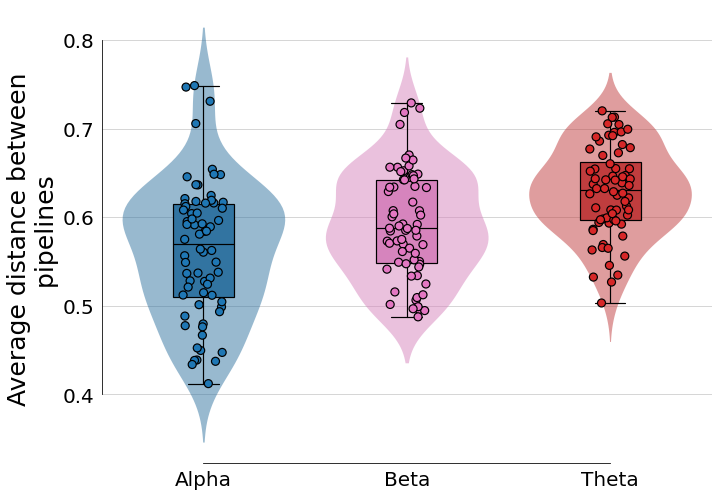

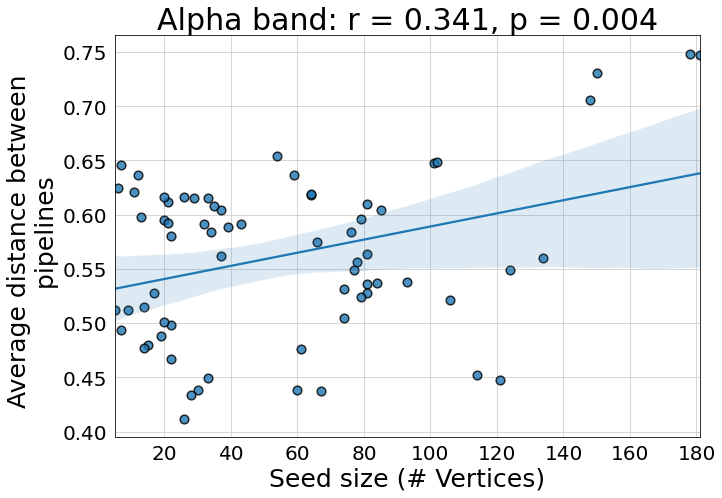

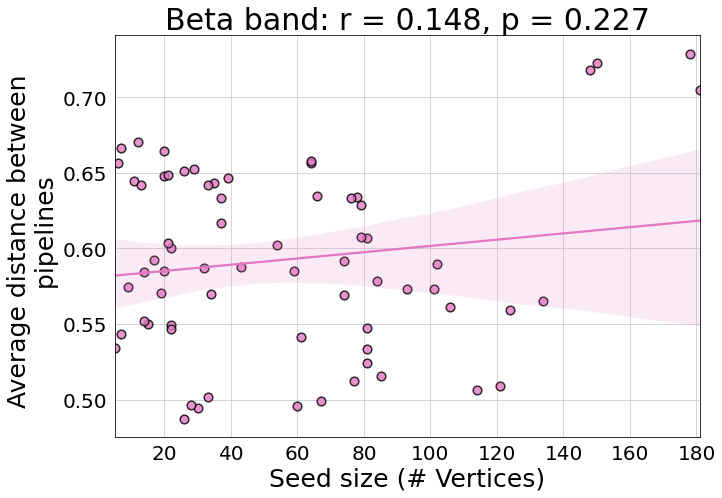

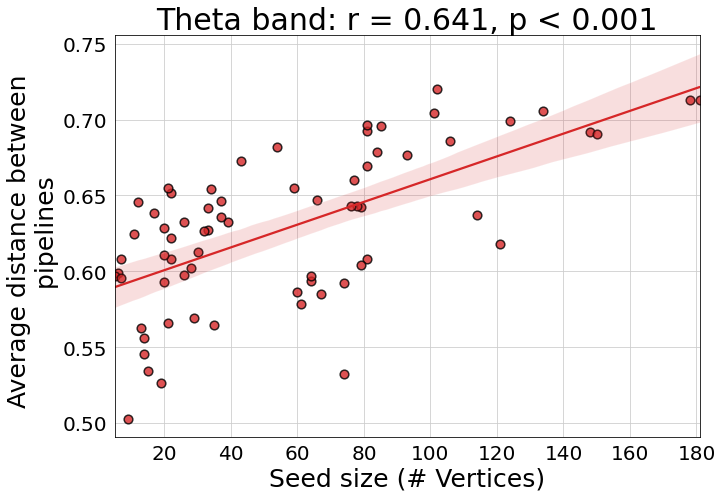

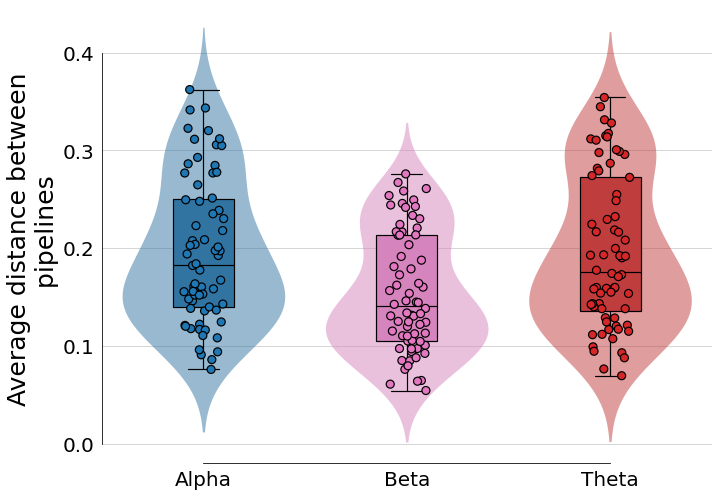

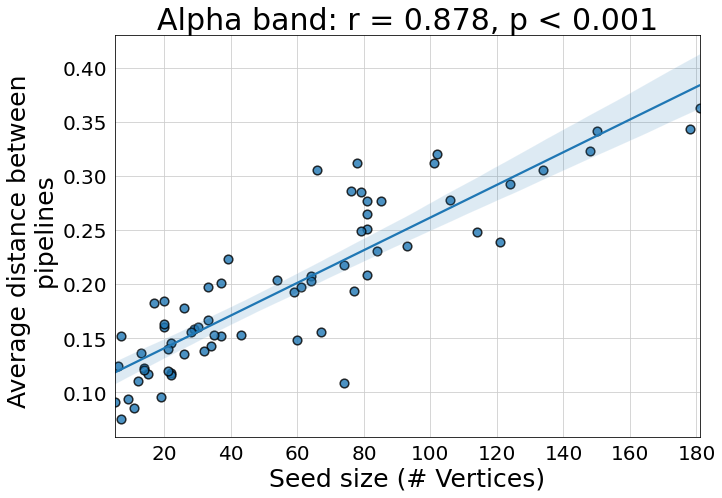

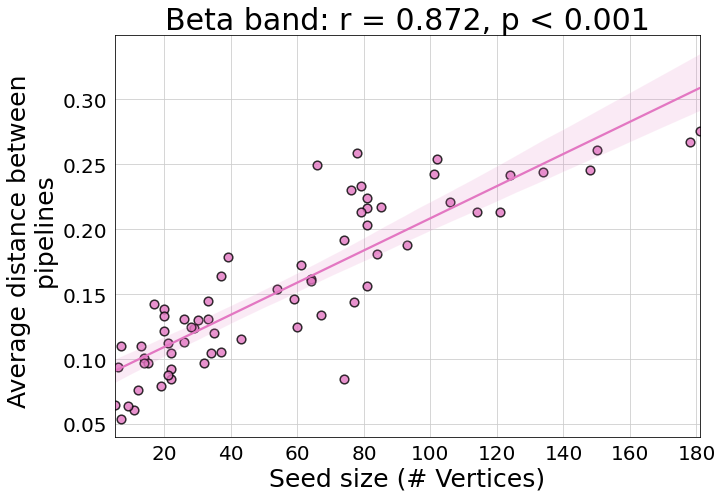

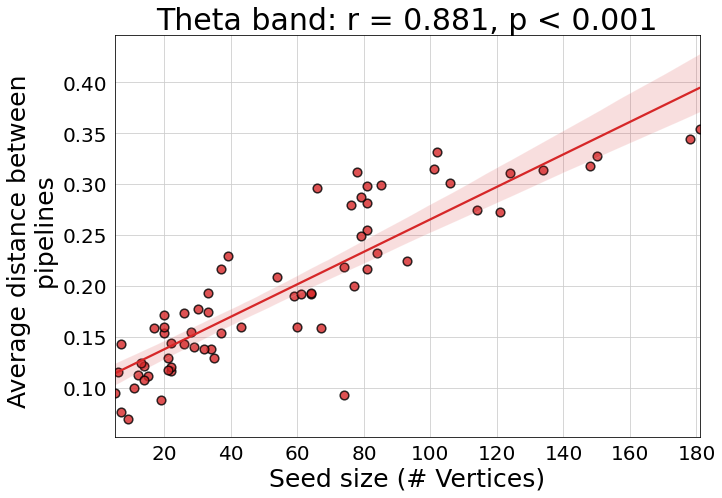

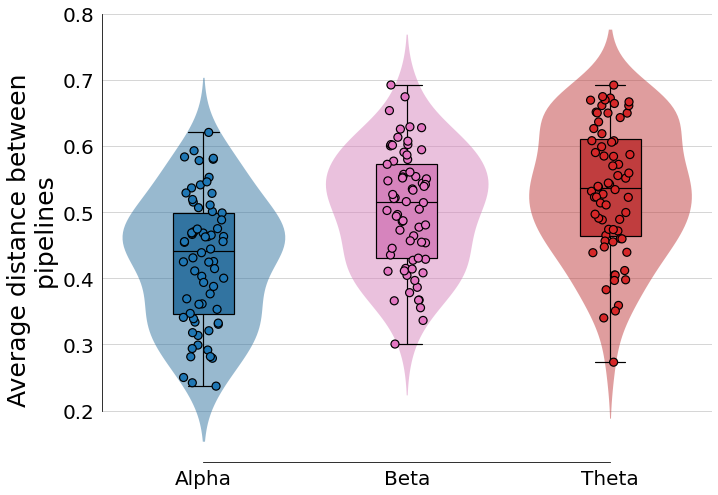

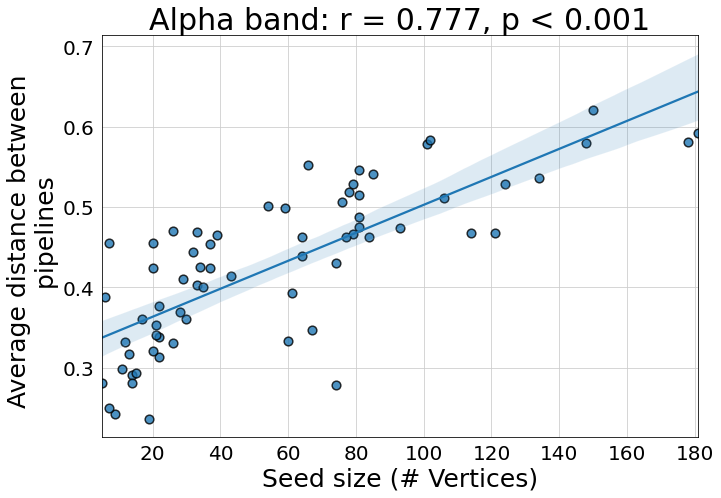

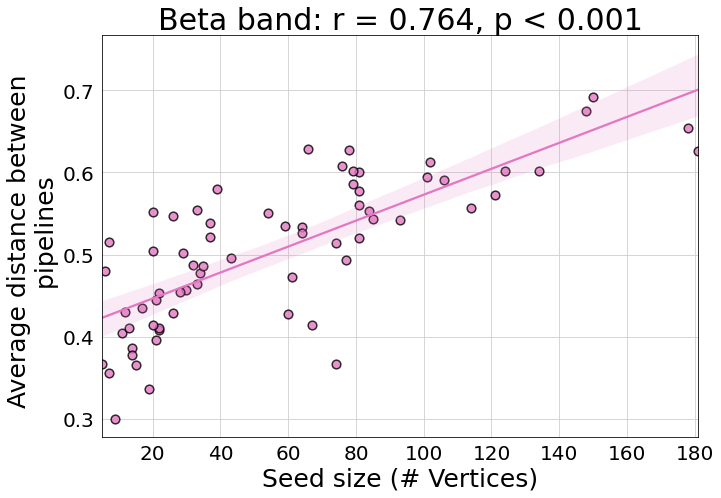

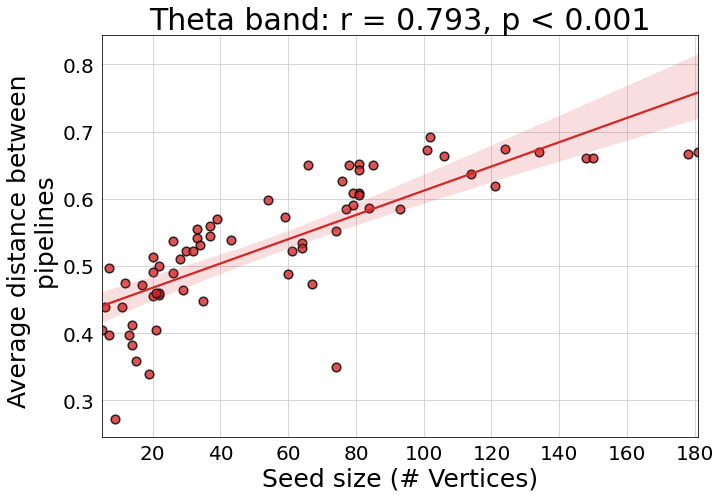

In [9]:
from scipy.io import loadmat
from glob import glob
from os.path import join as opj
from pathlib import Path

seed_size_df = pd.read_excel("data/Seed_Size.xlsx", header=None)

seed_size_df.columns = ["roi", "hemisphere", "Size"]

new_roi_labels = []
for x in seed_size_df.iterrows():
    roi, hemi, size = x[1]
    new_roi_labels.append("ctx-" +  hemi.lower() + "h-" + roi.lower())
    
seed_size_df = pd.DataFrame({"roi": new_roi_labels, "size": seed_size_df.Size})

for case, mask in zip(["both", "PLV", "ciPLV"], 
                      [range(8), range(4), range(4,8)]):
    case_dir = opj("plots", case)
    Path(case_dir).mkdir(exist_ok=True)
    
    similarities_dict = extract_similarities(mask)
    
    distances_dict = compute_distances(similarities_dict)
    
    dist_68_size = combine_d_size(distances_dict, seed_size_df)
    
    
    with sns.axes_style("whitegrid", rc={'axes.edgecolor':'black', 'text.color': '.0'}):
        fig, ax = plt.subplots(figsize=(10, 7))
        boxviolin_w_points(x="band", y="Average Distance", data=dist_68_size, ax=ax, 
                           points_kws={'size':8, 'linewidth':1.2, 'edgecolor': "black"})
        ax.tick_params(labelsize=20,  colors='0.')
        ax.set_ylabel("Average distance between \n pipelines", size=25, color='0.')
        ax.set_xlabel("")
        ax.set_xticklabels(["Alpha", "Beta", "Theta"])
        #ax.set_title(band[0].upper() + band[1:]+ f" band: r = {r:.3f}, {p}", size=30)
        plt.legend([],[], frameon=False)
        sns.despine(trim=True)
        plt.tight_layout()
        plt.savefig(opj(case_dir, "dist_vs_bands_68_python.png"), dpi=300)
        
        
    for band in ["alpha", "beta", "theta"]:

        if band=="alpha":
            color = sns.color_palette()[0]
        elif band=="beta":
            color = sns.color_palette()[6]
        else:
            color = sns.color_palette()[3]

        r,p = pearsonr(dist_68_size[dist_68_size.band==band]['Average Distance'], 
                       dist_68_size[dist_68_size.band==band]['size'])

        if p<0.001:
            p = "p < 0.001"
        else:
            p = f"p = {p:.3f}"


        with sns.axes_style("whitegrid", rc={'axes.edgecolor':'black', 'text.color': '.0'}):
            fig, ax = plt.subplots(figsize=(10, 7))
            sns.regplot(y='Average Distance', x='size', data=dist_68_size[dist_68_size.band==band], 
                    ax=ax, scatter_kws={'edgecolor':'black', 'linewidth':1.5, 's':75}, marker="o", color=color)
            ax.tick_params(labelsize=20,  colors='0.')
            ax.set_ylabel("Average distance between \n pipelines", size=25, color='0.')
            ax.set_xlabel(r'Seed size (# Vertices)', size=25, color='0.')
            ax.set_title(band[0].upper() + band[1:]+ f" band: r = {r:.3f}, {p}", size=30)
            plt.tight_layout()
            plt.savefig(opj(case_dir, f"dist_vs_size_{band}_68_python.png"), dpi=300)
    
    output_dir = opj("outputs", case)
    Path(output_dir).mkdir(exist_ok=True)
    generate_dist_imgs(distances_dict, output_dir)
    
    for band in ["alpha", "beta", "theta"]:
        for hemi in ["L", "R"]:
            ref_surface= f"data/Q1-Q6_R440.{hemi}.white.164k_fs_LR.surf.gii"
            cmd = f"wb_command -volume-to-surface-mapping outputs/{case}/d_{band}_68.nii.gz {ref_surface} outputs/{case}/d_{band}_{hemi}.shape.gii -enclosing"
            os.system(cmd)